# UK Electricity Consumption Forecast - Time Series Analysis

The general framework we will use to carryout the time series forecasting analysis is as follows:

### 1. **Data Wrangling: Understanding the Dataset**
- Load our dataset into a dataframe.
- Visualize the data to understand its pattern (e.g., using Matplotlib or Seaborn in Python). - Look for seasonality, trends, and potential outliers.
- Check for missing data and decide how we want to handle them (e.g., interpolation, forward-fill, or dropping).


### 2. **EDA: Decomposition of the Series**
Using the package `statsmodels.tsa.seasonal` in Python, we will decompose our time series into:
- Trend component
- Seasonal component
- Residual component

This gives us insights into the nature of the patterns in our data.

### 3. **Stationarity**
Most time series forecasting methods assume that the underlying time series is stationary, which means statistical properties like mean, variance, etc., are constant over time.

- Test for stationarity using the Dickey-Fuller test (`adfuller` function from `statsmodels.tsa.stattools`) and Kwiatkowski-Phillips-Schmidt-Shin test (`KPSS`function from `statsmodels.tsa.stattools`).
- If the series is non-stationary, we can make it stationary by differencing or taking the log, etc.

### 4. **Selecting a Model**
Below are the models we will use to forecast electricity demand in the UK:

- **ARIMA** (AutoRegressive Integrated Moving Average): A popular model for time series forecasting. We'll need to find optimal parameters (p,d,q) for the model. We can use tools like `auto_arima` in the `pmdarima` library to find the best parameters.

- **SARIMA** (Seasonal Autoregressive Integrated Moving Average). It's a statistical model used for forecasting time series data that exhibit seasonality.

- **Prophet**: Developed by Facebook, it's useful for datasets with strong seasonal patterns and multiple seasonality.

### 5. **Training and Testing**
- Split the dataset into a training set and a test set. The training set will be used to train the model, while the test set will be used to test its performance.
- Fit the selected model to the training data.
- Forecast for the test period and compare the forecasted values with the actual values.

### 6. **Model Evaluation**
Use metrics like Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), or Mean Absolute Error (MAE) to measure the accuracy of our forecasts.

### 7. **Forecasting**
Once satisfied with the model's performance on the test set, we can use the entire dataset to train the model and then forecast future consumption or demand.

### 8. **Post-processing**
Some models might give forecasts that need post-processing. For example, if we log-transformed our data, we'll need to reverse the transformation on our forecasts.

### Load relevant libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose  # Decomposition
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

### Load Data Wranging & EDA Data

In [2]:
# Load data from Parquet
folder_path = '/Users/elevate/Documents/Springboard Data Science/GitHub Repos/Capstone_3_Project/2. Data_Wrangling_EDA'

data_loaded = pd.read_parquet(f'{folder_path}/eda_output.parquet')

# Check first few rows to ensure data loaded correctly
data_loaded.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


**Note**: Before proceeding with Prophet, we need to make sure the data is structured in a way Prophet expects. The Prophet model expects the dataframe to have columns named "ds" (for the date or datetime) and "y" (for the value we want to forecast).

In [3]:
# The settlement_date' is ds and the 'tsd' column is 'value'
data_prophet = data_loaded.rename(columns={'settlement_date': 'ds', 'tsd': 'y'})

# Check the first few rows
print(data_prophet.head())

                   ds  settlement_period period_hour     nd      y  \
0 2009-01-01 00:00:00                  1     0:00:00  37910  38704   
1 2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2 2009-01-01 01:00:00                  3     1:00:00  37380  38651   
3 2009-01-01 01:30:00                  4     1:30:00  36426  37775   
4 2009-01-01 02:00:00                  5     2:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                  

In [5]:
# Extract holidays from data_loaded dataset
holiday_dates = data_loaded[data_loaded['is_holiday'] == 1]['settlement_date']

In [6]:
# Create a DataFrame for holidays
holidays = pd.DataFrame({
  'holiday': 'UK_Holiday',
  'ds': holiday_dates
})

### 4.0 Using Prophet Model

#### 4.1 Initialization

In [7]:
from prophet import Prophet

# Create a new Prophet Object
prophet_model = Prophet()

#### 4.2 Initialize the Prophet Model with holidays

In [8]:
prophet_model = Prophet(holidays=holidays)

#### 4.3 Fit the model on only 2 columns: `ds` and `y`

In [9]:
# Fit the model to our data
prophet_model.fit(data_prophet[['ds', 'y']])

16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processing


### 5.0 Training and Validation

#### 5.1 Split the dataset

In [10]:
train_size = int(0.8*len(data_prophet))
train_data = data_prophet[:train_size]
test_data = data_prophet[train_size:]

#### 5.2 Train the Prophet Model on Training Data

In [11]:
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(train_data)

16:29:00 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] done processing


#### 5.3 Make Predictions on test set's date range
- To forecast with Prophet, we first have to create a dataframe with the dates for which we want a prediction.

In [12]:
future_dates = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')
forecast = prophet_model.predict(future_dates)

In [13]:
# The predictions corresponding to the test set are the last rows of the forecast
predictions = forecast['yhat'][train_size:].values

### 6.0 Model Evaluation

In [14]:
# Evaluate the model using RMSE
actual_values = test_data['y'].values
rmse = np.sqrt(((predictions - actual_values) ** 2).mean())

In [15]:
print(f'RMSE: {rmse}')

RMSE: 10881.925420402475


### 7.0 Forecasting

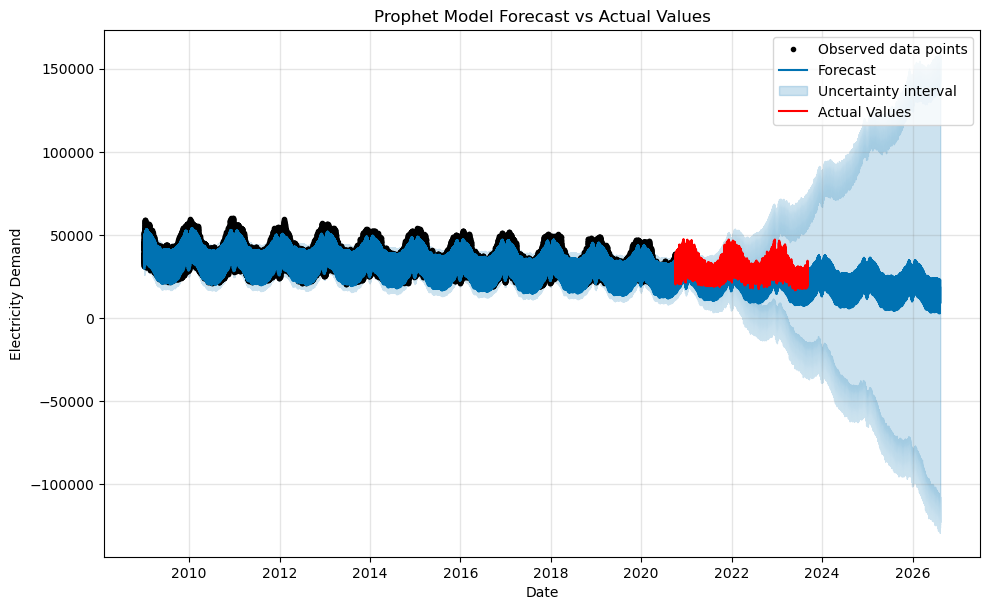

In [20]:
# Use Prophet's built-in plotting function
fig = prophet_model.plot(forecast)

# Overlay the actual values from the test set
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual Values')
plt.legend()

plt.title('Prophet Model Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()

**Plot Interpretation**:

 - The plot of the Prophet forecast is in blue (with uncertainty intervals in light blue) and the actual values from the test set are in red. 
 - This visual comparison gives a clear idea of how well the Prophet model has performed in predicting electricity demand in the test set's timeframe.
 
 - The visual overlay of actual vs. forecasted values also provides a quick way to gauge model performance. Since the plots closely follow each other, it means the model is capturing the underlying patterns in the data.

#### 7.1 Forecasting on Full Dataset

In [21]:
# Retrain the model on the entire dataset
prophet_model_full = Prophet(holidays=holidays)
prophet_model_full.fit(data_prophet)

17:02:02 - cmdstanpy - INFO - Chain [1] start processing
17:05:08 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Create a future dataframe that extends beyond the current dataset
# Forecast the next 48 periods given our data's granularity).
future_full = prophet_model_full.make_future_dataframe(periods=48, freq='H')

In [23]:
# Forecast with the Prophet model
forecast_full = prophet_model_full.predict(future_full)

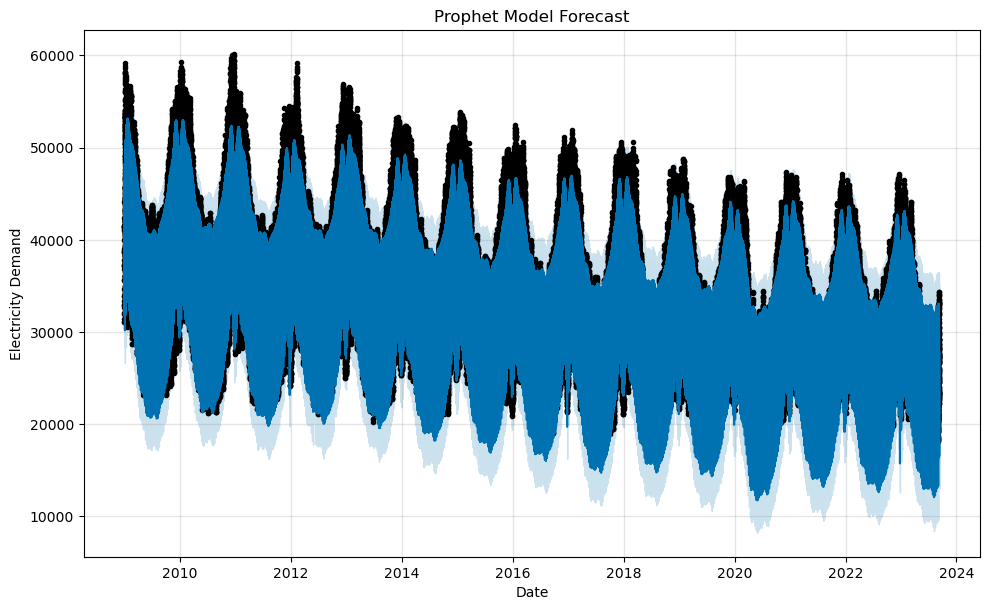

In [24]:
# Plot the forecast
fig_full = prophet_model_full.plot(forecast_full)
plt.title('Prophet Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()

#### 7.2 Inspecting Forecast Components

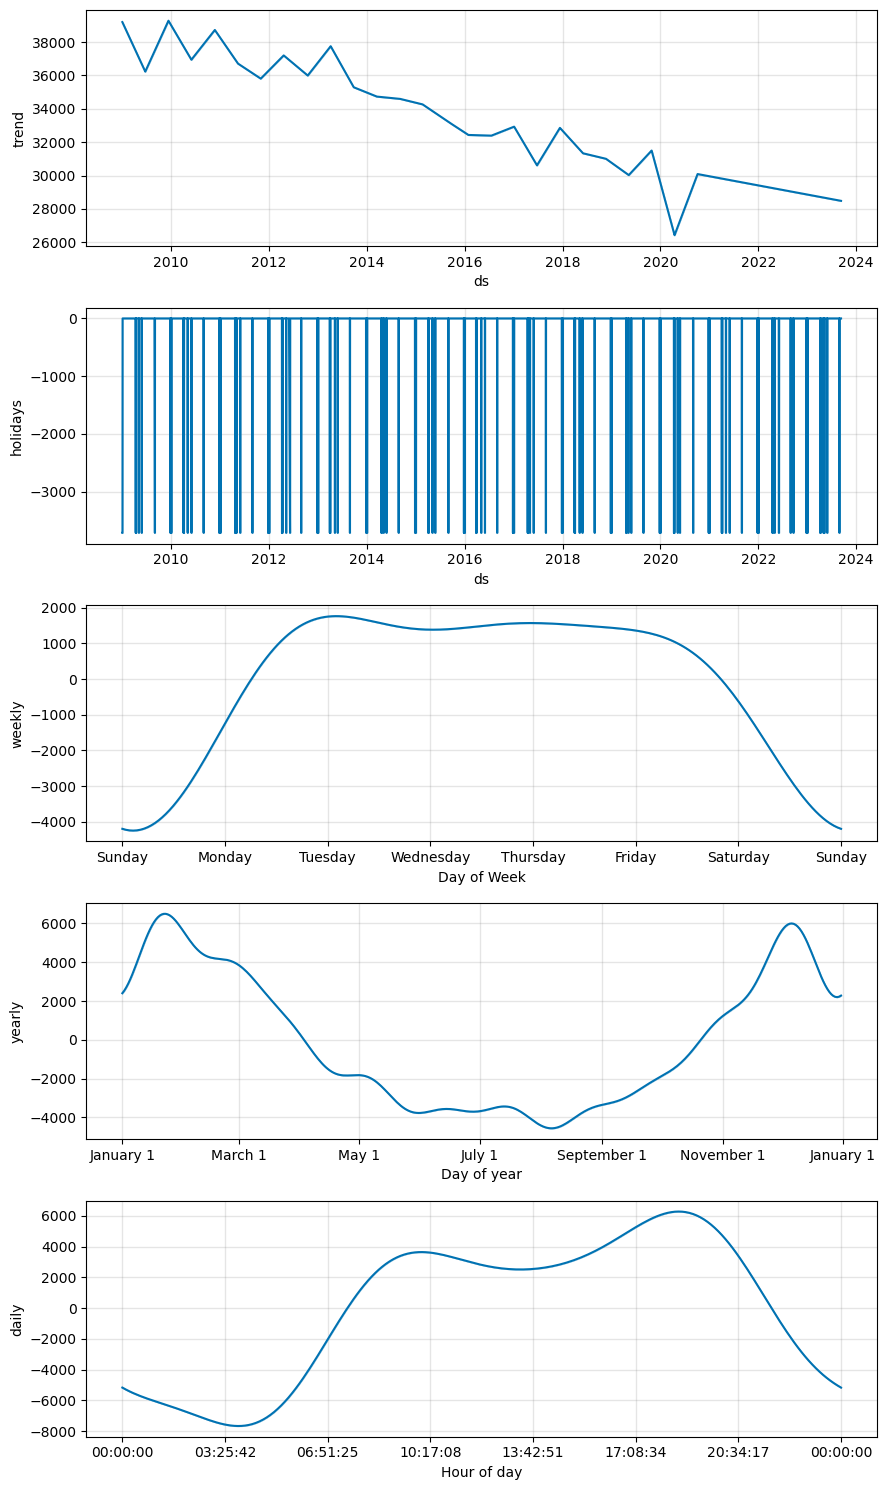

In [25]:
fig_components = prophet_model_full.plot_components(forecast_full)

### Model Results Interpretation

In [26]:
# Find the range of our dataset
data_range = data_prophet['y'].max() - data_prophet['y'].min()

print(f"The range of the data is: {data_range}")

The range of the data is: 43634


**Interpretating Model Evaulation Results**:

- The Root Mean Square Error (RMSE) is a standard measure used to evaluate the accuracy of a model's predictions. It provides an aggregate of the differences between the actual and forecasted values. 
- The smaller the RMSE, the better the model's performance. 
    - Here's a breakdown of what the RMSE value indicates:
        - On average, the model's forecasts were about 10,882 Megawatt-hours off from the actual values.
        - Considering that the total variation in our data spans 43,634 units, an average error of 10,881.93 units means the model's errors are roughly a quarter of the full range of the data.
   

### Conclusion

- How good or bad is our model? That depends on whether being off by 25% of the data is acceptable or not.
- Our SARIMA model's RMSE (411.27) represents less than 1% of our data range (43,634) which implies that, on average, the SARIMA model's predictions are off by about 411.27 units from the actual values.
- This means that our SARIMA model is significantly more accurate in its predictions that the prophet model, given its much lower RMSE value.
    - This can be explained by the fact that the SARIMA, being tailored for time series with clear seasonality and trends, is able to capture the underlying patterns in our electricity demand data better than Prophet. 

- Therefore, given the stark difference in RMSE, if we had to choose a model based solely on this metric, the SARIMA model would be the preferred choice for forecasting electricity demand in Great Britain for this particular dataset.